In [1]:
import numpy as np 
from numba import njit, prange
import matplotlib.pyplot as plt 

In [2]:
#Variables to test
#These variables should later on have permanent values, unliked temp and RH which may change values

attach_prob_divisor = 100 #This determines how the attach prob should be divided. Attach prob is proportional to Max M-value given conditions
#Max M-value corresponds to a certain coverage percentage. This should be divided by something to get attach probability. Minimum 100. 

decay_prob_multiplier  = 0.05 #Makes everyone have lower/higher decay rate
timesteps_per_day = 300 #We need to be able to talk about how many days have passed, to be able to compare it to experimental data. 
exponential_drop_off = 10 #Lower value means higher rate of decay, but affects lower attach_prob values more than higher ones.


In [3]:
# Constants
GRID_SIZE = 100
RADIUS = GRID_SIZE//2
SEED = (GRID_SIZE // 2, GRID_SIZE // 2)  # Seed in the middle of the grid
DAYS = 168
TIMESTEPS = DAYS * timesteps_per_day
NUM_SIMS = 1
Temp = 5
RH = 100

In [4]:
def attaching_prob(Temp, RH): 
    RH_crit = (-0.00267 * (Temp**3)) + (0.16*(Temp**2)) - (3.13*Temp) + 100
    if(RH < RH_crit):
        return 0
    M_max = 1+7*((RH_crit-RH)/(RH_crit-100))-2*((RH_crit - RH)/(RH_crit-100))**2 #The maximum M-value for the given temperature and relative humidity 
    #The above two formulas are from the paper "A mathematical model of mould growth on wooden material" by Hukka and Vitten 1999
    if(M_max < 0): 
        return 0


    area_covered = 117.5793 + (1.100592 - 117.5793)/(1 + (M_max/4.736148)**6.118612)

    #The formula for translating M-value to surface coverage represented by that coverage, is retrieved by regression over the definition of M-value.
    #We use this as a stand-in for attachment probability. 
    #The regression is over the points (0,0), (1,1), (3,10), (4,30), (5,70), (6,95)
    #These are the points where the M-value is 0, 1, 3, 4, 5, 6, respectively as given by the table in "Development of an improved model for mould growth: Modelling"  
    #by Viitanen et al. 2008
    if area_covered > 100:
        return 1
    return area_covered/attach_prob_divisor

In [5]:
@njit
def coverage_to_m_value(cov): 
    #calculates M-value from coverage percentage, using regression over the points (0,0), (1,1), (3,10), (4,30), (5,70), (6,95)
    return 24.88976 + (-0.03418982 - 24.88976)/(1 + (cov/1674.627)**0.4037152)

In [6]:
@njit(parallel=True)
def decay_grid(DECAY_PROB, grid):
    decay_amount = 0
    for _ in prange(np.sum(grid)):
        if np.random.uniform() < DECAY_PROB:
            decay_amount += 1
    if decay_amount == 0:
        return
    # find middle point
    coords = np.zeros((np.sum(grid), 2), dtype=np.int32)
    idx = 0
    x_avg = 0
    y_avg = 0
    for x in prange(grid.shape[0]):
        for y in range(grid.shape[1]):
            if grid[x, y] == 1:
                coords[idx] = np.array((x, y), dtype=np.int32)
                x_avg += x
                y_avg += y
                idx += 1

    x_avg /= idx
    y_avg /= idx
    middle = (x_avg, y_avg)
    
    # keep removing furthest point from middle point
    distances = np.zeros(coords.shape[0])
    for i in prange(coords.shape[0]):
        distances[i] = np.sqrt((coords[i][0] - middle[0]) ** 2 + (coords[i][1] - middle[1]) ** 2)
    for _ in prange(decay_amount):
        idx = np.argmax(distances)
        furthest = coords[idx]
        grid[int(furthest[0]), int(furthest[1])] = 0
        distances[idx] = -1


ATTACH_PROB = attaching_prob(Temp, RH)


In [7]:
def get_decay_prob(ATTACH_PROB, decay_prob_multiplier, exponential_drop_off): 
    #Using exponential function to calculate decay rate, such that changes in attach prob are "felt more"
    return np.exp(-ATTACH_PROB * exponential_drop_off) * decay_prob_multiplier

In [8]:
@njit(parallel=True)
def mold_coverage(grid, grid_size = 5):
    #Uses grid sampling to smarter estimate mold coverage. Divides the grid into 10x10 squares and counts the number of squares with mold.
    height, width = grid.shape
    cells_x = width // grid_size
    cells_y = height // grid_size

    covered_cells = 0
    total_cells = cells_x * cells_y

    for i in prange(cells_y):
        for j in prange(cells_x):
            # Extract grid cell
            cell = grid[i * grid_size:(i + 1) * grid_size, j * grid_size:(j + 1) * grid_size]

            # Check if there's any mold in the cell
            if np.any(cell > 0):  # Assuming mold is white (255) and background is black (0)
                covered_cells += 1
    if covered_cells == 1: 
        return 0

    return (covered_cells / total_cells) * 100


In [9]:
@njit # This decorator tells Numba to compile this function using the JIT (just-in-time) compiler
def particle_loop(GRID_SIZE, grid, ATTACH_PROB, TIMESTEPS, DECAY_PROB, DAYS):
    Reached_edge = False
    current_radius = 20 #spawns particles closer to where the seed is, to speed up the program. 
    timesteps_per_day = int(TIMESTEPS/DAYS)
    m_history = np.zeros(DAYS)

    for i in range(TIMESTEPS):

        if i % timesteps_per_day == 0:
            #These things happen once a day
            decay_grid(DECAY_PROB, grid)
            #Append m-value of the day to the histories array, such that we can plot it later
            m_history[i // timesteps_per_day] = coverage_to_m_value(mold_coverage(grid))

        if Reached_edge == False:
            angle = np.random.uniform(0, 2 * np.pi) # Random angle in radians
            particle = (int(GRID_SIZE/2 + current_radius * np.cos(angle)), int(GRID_SIZE/2 + current_radius * np.sin(angle)))
        else: 
            particle = (np.random.randint(0, GRID_SIZE), np.random.randint(0, GRID_SIZE))
        while True:
            # Create the particle starting from a random point on the circle
            #use angle and spawn point of seed (which is the middle of the grid) ...
            # ... to calculate the x and y coordinates of a new particle. Cast it to int also. 

            dist_to_seed = np.sqrt((particle[0] - GRID_SIZE/2) ** 2 + (particle[1] - GRID_SIZE/2) ** 2)
            
            # Check if particle is out of bounds (ensure it's within grid size)
            if Reached_edge == False and dist_to_seed >= current_radius + 20:
                break
            elif Reached_edge == True and (particle[0] < 0  or particle[1] < 0 or particle[0] >= GRID_SIZE or particle[1] >= GRID_SIZE ):
                break

            # Check if the particle can attach to any adjacent grid cell (touches the cluster)
            if (grid[particle[0] + 1, particle[1]] == 1 or
                grid[particle[0] - 1, particle[1]] == 1 or
                grid[particle[0], particle[1] + 1] == 1 or
                grid[particle[0], particle[1] - 1] == 1):


                if np.random.uniform() < ATTACH_PROB:
                    grid[particle[0], particle[1]] = 1  # Attach particle to the grid
                    if dist_to_seed >= current_radius-1 and Reached_edge == False:
                        current_radius += 20
                        if current_radius >= GRID_SIZE/2:
                            Reached_edge = True
                
                break  # Once the particle reaches a neighbor, it is either attached or killed. Either way the loop breaks
                

            # Move the particle randomly until we pass the loop manually
            move = np.random.randint(0, 4)  # Randomly select one of four directions
            if move == 0:
                particle = (particle[0], particle[1] + 1)  # Move up
            elif move == 1:
                particle = (particle[0] + 1, particle[1])  # Move right
            elif move == 2:
                particle = (particle[0], particle[1] - 1)  # Move down
            elif move == 3:
                particle = (particle[0] - 1, particle[1])  # Move left
                
    return m_history

In [10]:
@njit(parallel=True)
def monte_carlo(GRID_SIZE, ATTACH_PROB, TIMESTEPS, NUM_SIMS, DECAY_PROB, DAYS):
    aggr_grid = np.zeros((GRID_SIZE + 1, GRID_SIZE + 1))
    mold_cov = 0
    m_histories = np.zeros((NUM_SIMS, DAYS))
    

    for i in prange(NUM_SIMS):
        # Initialize grid (plus 1 to account for 0-index)
        grid = np.zeros((GRID_SIZE + 1, GRID_SIZE + 1), dtype=np.int32)
        grid[SEED[0], SEED[1]] = 1  # Set seed point as part of cluster
        m_histories[i] = particle_loop(GRID_SIZE, grid, ATTACH_PROB, TIMESTEPS, DECAY_PROB, DAYS)
        aggr_grid += grid
        mold_cov += mold_coverage(grid)

    return aggr_grid/NUM_SIMS, mold_cov/NUM_SIMS, m_histories

In [11]:


#final_grid, mold_cov, m_histories = monte_carlo(GRID_SIZE, ATTACH_PROB, TIMESTEPS, NUM_SIMS, DECAY_PROB, DAYS)
#print("attach_prob:" , ATTACH_PROB)
#print("decay_prob: ", DECAY_PROB)
#print("Average mold coverage: ", mold_cov , "%")
#print("M-value: ", coverage_to_m_value(mold_cov))
#print("Temperature: "   , Temp)
#print("Relative Humidity: " , RH)
# #Plot the result
#plt.imshow(final_grid, cmap='Greys', interpolation='nearest')
#plt.show()

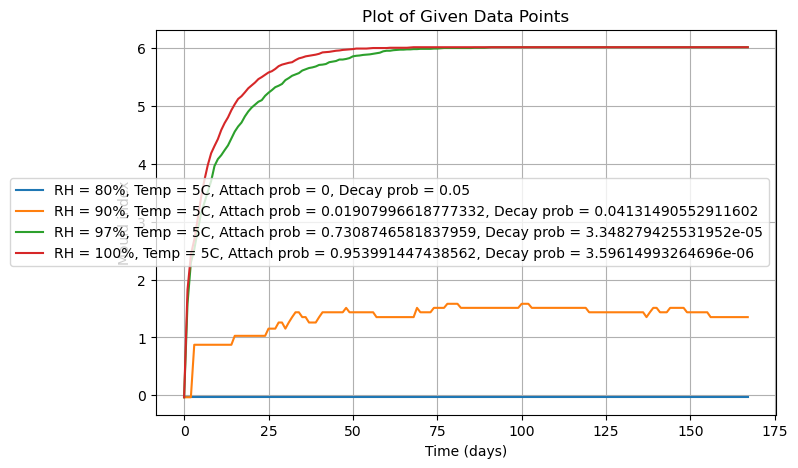

In [12]:
#Graphs to compare with experimental data
RH_list = [80, 90, 97, 100]
Temp_list = [5]
plt.figure(figsize=(8, 5))

for i in RH_list:
    for j in Temp_list:
        attach_prob = attaching_prob(j, i)
        decay_prob = get_decay_prob(attach_prob, decay_prob_multiplier, exponential_drop_off)
        _,_, m_histories = monte_carlo(GRID_SIZE, attach_prob, TIMESTEPS, NUM_SIMS, decay_prob, DAYS)
        plt.plot(m_histories[0],linestyle='-', label=f"RH = {i}%, Temp = {j}C, Attach prob = {attach_prob}, Decay prob = {decay_prob}")





plt.xlabel("Time (days)")
plt.ylabel("Mould index")
plt.title("Plot of Given Data Points")
plt.legend()
plt.grid(True)

# Show plot
plt.show()

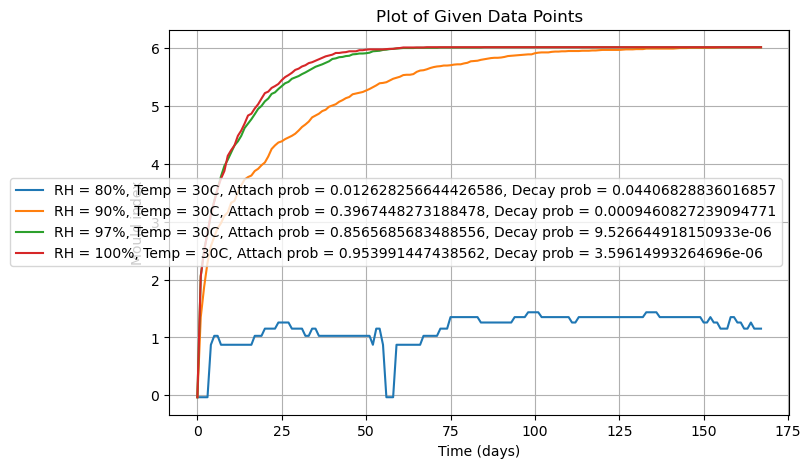

In [13]:
#Graphs to compare with experimental data
RH_list = [80, 90, 97, 100]
Temp_list = [30]
plt.figure(figsize=(8, 5))

for i in RH_list:
    for j in Temp_list:
        attach_prob = attaching_prob(j, i)
        decay_prob = get_decay_prob(attach_prob, decay_prob_multiplier, exponential_drop_off)
        _,_, m_histories = monte_carlo(GRID_SIZE, attach_prob, TIMESTEPS, NUM_SIMS, decay_prob, DAYS)
        plt.plot(m_histories[0],linestyle='-', label=f"RH = {i}%, Temp = {j}C, Attach prob = {attach_prob}, Decay prob = {decay_prob}")




plt.xlabel("Time (days)")
plt.ylabel("Mould index")
plt.title("Plot of Given Data Points")
plt.legend()
plt.grid(True)

# Show plot
plt.show()